# Credits
TensorFlow translation of [Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb). Thanks to [skaae](https://github.com/skaae), [casperkaae](https://github.com/casperkaae) and [larsmaaloee](https://github.com/larsmaaloee).

# Dependancies and supporting functions
Loading dependancies and supporting functions by running the code block below.

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph

# Do not worry about the code below for now, it is used for plotting later
def plot_decision_boundary(pred_func, X, y):
    #from https://github.com/dennybritz/nn-from-scratch/blob/master/nn-from-scratch.ipynb
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    yy = yy.astype('float32')
    xx = xx.astype('float32')
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])[:,0]
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=-y, cmap=plt.cm.Spectral)

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

# Neural networks 101
In this notebook you will implement a simple neural network in TensorFlow utilizing the graph building and automatic differentiation engine of TensorFlow. We assume that you are already familiar with backpropagation (if not please see [Andrej Karpathy](http://cs.stanford.edu/people/karpathy/) or [Michal Nielsen](http://neuralnetworksanddeeplearning.com/chap2.html).
We'll not spend much time on how TensorFlow works, but you can refer to [this short tutorial](https://www.tensorflow.org/versions/r0.10/get_started/basic_usage.html) if you are interested, or [the python documentation](https://www.tensorflow.org/versions/r0.10/api_docs/index.html).

(Additionally, for the ambitious people we have previously made an assignment where you will implement both the forward and backpropagation in a neural network by hand, https://github.com/DTU-deeplearning/day1-NN/blob/master/exercises_1.ipynb)(Ole, skal jeg også implementere det?)

In this exercise we'll start right away by defining logistic regression model in TensorFlow. Some details of TensorFlow can be a bit confusing, however you'll pick them up when you worked with it for some time. We'll initially start with a simple 2-D and 2-class classification problem where the class decision boundary can be visualized. Initially we show that logistic regression can only separate classes linearly. Adding a Non-linear hidden layer to the algorithm permits nonlinear class separation. If time permits we'll continue on to implement a fully conencted neural network to classify the (in)famous MNIST dataset consisting of images of hand written digits.

# Problem 
We'll initally demonstrate the that MLPs can classify non-linear problems whereas simple logistic regression cannot. For ease of visualization and computationl speed we initially experiment on the simple 2D half-moon dataset.

((300, 2), (300,))


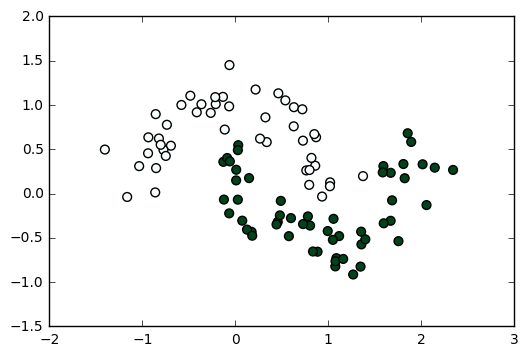

In [6]:
# Generate a dataset and plot it
np.random.seed(0)
num_samples = 300

X, y = sklearn.datasets.make_moons(num_samples, noise=0.20)

X_tr = X[:100].astype('float32')
X_val = X[100:200].astype('float32')
X_te = X[200:].astype('float32')

y_tr = y[:100].astype('int32')
y_val = y[100:200].astype('int32')
y_te = y[200:].astype('int32')

plt.scatter(X_tr[:,0], X_tr[:,1], s=40, c=y_tr, cmap=plt.cm.BuGn)

print(X.shape, y.shape)

num_features = X_tr.shape[-1]
num_output = 2

# From Logistic Regression to "Deep Learning" in Lasagne
The code implements logistic regression in TensorFlow. In section __Assignments Half Moon__ you are asked to modify the code into a neural network.

The building blocks of TensorFlow are variables and operations, with these we can form computational graphs that form neural networks.

The [tf.placeholder](https://www.tensorflow.org/versions/r0.10/api_docs/python/io_ops.html#placeholder) allows us to feed our input data to the computational graph. We can define constraints with the shape of the placeholder to only take a tensor of a certain shape. Note that it is common to provide ``None`` for the first dimension, which allows us to vary the batch size at runtime.

The [tf.Variable](https://www.tensorflow.org/versions/r0.10/api_docs/python/state_ops.html#Variable) allows us to store and update Tensors in our graph. Variables are used to build weights for our neural network. Note that we will use a wrapper called [`tf.get_variable`](https://www.tensorflow.org/versions/r0.10/api_docs/python/state_ops.html#get_variable) througout this tutorial.

The [tf.Operation](https://www.tensorflow.org/versions/r0.10/api_docs/python/framework.html#Operation) allows us to perform operations on tensors, resulting in new tensors. Such as when computing the logistic regression which is implemented below:

$$y = nonlinearity(xW + b)$$

where $x$ is the input tensor, $y$ is the output tensor and $\{W, b\}$ are the weights (variable tensors). The weights are initialized with an initializer of our choice (check [tensorflow's API](https://www.tensorflow.org/versions/r0.10/api_docs/index.html) for more.
x has shape ```[batchsize, num_features]```. ```W``` has shape ```[num_features, num_units]``` and b has ```[num_units]```. y has then ```[batch_size, num_units]```.

NOTE: to make building neural networks easier, TensorFlow's [contrib](https://www.tensorflow.org/versions/r0.10/api_docs/python/contrib.layers.html#layers-contrib) wraps TensorFlow functionality to support various operations such as; [convolutions](https://www.tensorflow.org/versions/r0.10/api_docs/python/contrib.layers.html#convolution2d), [batch_norm](https://www.tensorflow.org/versions/r0.10/api_docs/python/contrib.layers.html#batch_norm), [fully_connected](https://www.tensorflow.org/versions/r0.10/api_docs/python/contrib.layers.html#fully_connected).

In this first exercise we will use basic TensorFlow functions so that you can learn how to build it from scratch. This will help you later if you want to build your own custom operations.

## TensorFlow Playerground

If you are new to Neural Networks, start by using the [TensorFlow playground](http://playground.tensorflow.org/) to familiarize yourself with hidden layers, hidden units, activations, learning rate, etc.

In [7]:
# resets the graph, needed when initializing weights multiple times, like in this notebook
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
x_pl = tf.placeholder(tf.float32, [None, num_features])

# Setting up variables, these variables are weights in your network that can be update while running our graph.
# Notice, to make a hidden layer, the weights needs to have the following dimensionality
# W[number_of_units_going_in, number_of_units_going_out]
# b[number_of_units_going_out]
# in the example below we have 2 input units (num_features) and 2 output units (num_output)
# so our weights become W[2, 2], b[2]
# if we want to make a hidden layer with 100 units, we need to define the shape of the
# first weight to W[2, 100], b[2] and the shape of the second weight to W[100, 2], b[2]

# defining our initializer for our weigths from a normal distribution (mean=0, std=0.1)
weight_initializer = tf.truncated_normal_initializer(stddev=0.1)
with tf.variable_scope('l_1'): # if you run it more than once, reuse has to be True
    W_1 = tf.get_variable('W', [num_features, 100], # change num_output to 100 for mlp
                          initializer=weight_initializer)
    b_1 = tf.get_variable('b', [100], # change num_output to 100 for mlp
                          initializer=tf.constant_initializer(0.0))
with tf. variable_scope('l_2'):
     W_2 = tf.get_variable('W', [100, num_output],
                           initializer=weight_initializer)
     b_2 = tf.get_variable('b', [num_output],
                           initializer=tf.constant_initializer(0.0))

# Setting up ops, these ops will define edges along our computational graph
# The below ops will compute a logistic regression, but can be modified to compute
# a neural network

l_1 = tf.matmul(x_pl, W_1) + b_1
# to make a hidden layer we need a nonlinearity
l_1_nonlinear = tf.nn.relu(l_1)
# the layer before the softmax should not have a nonlinearity
l_2 = tf.matmul(l_1_nonlinear, W_2) + b_2
y = tf.nn.softmax(l_2) # change to l_2 for MLP

In [8]:
# knowing how to print your tensors and ops is useful, here are some examples
print("---placeholders---")
print(x_pl.name)
print(x_pl)
print
print("---weights---")
print(W_1.name)
print(W_1.get_shape())
print(W_1)
print
print(b_1.name)
print(b_1)
print(b_1.get_shape())
print
print("---ops---")
print(l_1.name)
print(l_1)
print
print(y.name)
print(y)

---placeholders---
Placeholder:0
Tensor("Placeholder:0", shape=(?, 2), dtype=float32)

---weights---
l_1/W:0
(2, 100)
Tensor("l_1/W/read:0", shape=(2, 100), dtype=float32)

l_1/b:0
Tensor("l_1/b/read:0", shape=(100,), dtype=float32)
(100,)

---ops---
add:0
Tensor("add:0", shape=(?, 100), dtype=float32)

Softmax:0
Tensor("Softmax:0", shape=(?, 2), dtype=float32)


After we have built the network we have our tensors in our default [graph](https://www.tensorflow.org/versions/r0.10/api_docs/python/framework.html#Graph), which we can use to build the cost function and training part.

Further, using our default graph we can print the operations and variables of our default graph.

In [9]:
# y_ is a placeholder variable taking on the value of the target batch.
y_ = tf.placeholder(tf.float32, [None, num_output])

# computing cross entropy per sample
cross_entropy = -tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])

# averaging over samples
cross_entropy = tf.reduce_mean(cross_entropy)

Notice that our weights and operations defined in the `l_1` space are saved in the `l_1` directory of the graph.

In [10]:
# using the graph to print ops
print("operations")
operations = [op.name for op in tf.get_default_graph().get_operations()]
print(operations)
print
# variables are accessed through tensorflow
print("variables")
variables = [var.name for var in tf.all_variables()]
print(variables)

operations
[u'Placeholder', u'l_1/W', u'l_1/W/Initializer/truncated_normal/shape', u'l_1/W/Initializer/truncated_normal/mean', u'l_1/W/Initializer/truncated_normal/stddev', u'l_1/W/Initializer/truncated_normal/TruncatedNormal', u'l_1/W/Initializer/truncated_normal/mul', u'l_1/W/Initializer/truncated_normal', u'l_1/W/Assign', u'l_1/W/read', u'l_1/b', u'l_1/b/Initializer/Const', u'l_1/b/Assign', u'l_1/b/read', u'l_2/W', u'l_2/W/Initializer/truncated_normal/shape', u'l_2/W/Initializer/truncated_normal/mean', u'l_2/W/Initializer/truncated_normal/stddev', u'l_2/W/Initializer/truncated_normal/TruncatedNormal', u'l_2/W/Initializer/truncated_normal/mul', u'l_2/W/Initializer/truncated_normal', u'l_2/W/Assign', u'l_2/W/read', u'l_2/b', u'l_2/b/Initializer/Const', u'l_2/b/Assign', u'l_2/b/read', u'MatMul', u'add', u'Relu', u'MatMul_1', u'add_1', u'Softmax', u'Placeholder_1', u'Log', u'mul', u'Sum/reduction_indices', u'Sum', u'Neg', u'Const', u'Mean']

variables
Instructions for updating:
Please u

To train our neural network we need to update the parameters in direction of the negative gradient w.r.t the cost function we defined earlier.
We can use `tf.train.Optimizer` to get the gradients (using `compute_gradients`) for all parameters in the network w.r.t ``cost_train``.
Imagine that `cost_train` is a function and we want to go downhill. We go downhill by changing the value of the paramters in direction of the negative gradient. 

Finally we can use the built-in `minimize` to calculate the stochastic gradient descent (SGD) update rule for each paramter in the network.

Heres a small animation of gradient descent: http://imgur.com/a/Hqolp . E.g why saddle points might be difficult.
To use the other optimizers checkout which optimizers TensorFlow [supports](https://www.tensorflow.org/versions/r0.10/api_docs/python/train.html#optimizers)

In [11]:
# Defining our optimizer (try with different optimizers here!)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

# Computing our gradients
grads_and_vars = optimizer.compute_gradients(cross_entropy)

# Applying the gradients
train_op = optimizer.apply_gradients(grads_and_vars)

# Notice, alternatively you can use train_op = optimizer.minimize(crossentropy)
# instead of the three steps above

Next, we make the prediction functions, such that we can get an accuracy measure over a batch

In [12]:
# making a one-hot encoded vector of correct (1) and incorrect (0) predictions
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))

# averaging the one-hot encoded vector
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

The next step is to utilize our `train_op` function repeatedly in order to optimize our weights `W_1` and `b_1` to make the best possible linear seperation of the half moon dataset.

It is worth or read a short introduction on TensorFlow [sessions](https://www.tensorflow.org/versions/r0.10/api_docs/python/client.html#Session) before continuing to the next codeblock. Sessions are used to run TensorFlow graphs, they uses `fetches` to decide which parts of the graph to compute and `feed_dicts` to load data into the graph.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch 0, Train Cost: 0.714	Val Cost: 0.706	 Val acc: 0.340
Epoch 100, Train Cost: 0.330	Val Cost: 0.349	 Val acc: 0.830
Epoch 200, Train Cost: 0.296	Val Cost: 0.324	 Val acc: 0.810
Epoch 300, Train Cost: 0.287	Val Cost: 0.319	 Val acc: 0.810
Epoch 400, Train Cost: 0.279	Val Cost: 0.314	 Val acc: 0.840
Epoch 500, Train Cost: 0.270	Val Cost: 0.308	 Val acc: 0.840
Epoch 600, Train Cost: 0.260	Val Cost: 0.299	 Val acc: 0.860
Epoch 700, Train Cost: 0.247	Val Cost: 0.288	 Val acc: 0.860
Epoch 800, Train Cost: 0.230	Val Cost: 0.273	 Val acc: 0.870
Epoch 900, Train Cost: 0.210	Val Cost: 0.255	 Val acc: 0.890

Test Cost: 0.176	Test Accuracy: 0.930


(<matplotlib.text.Text at 0x7f6dcf9d99d0>,
 <matplotlib.text.Text at 0x7f6dca20d590>)

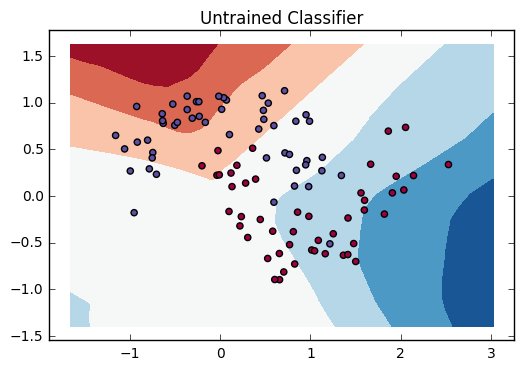

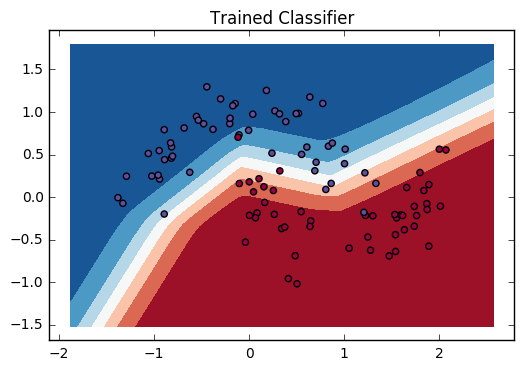

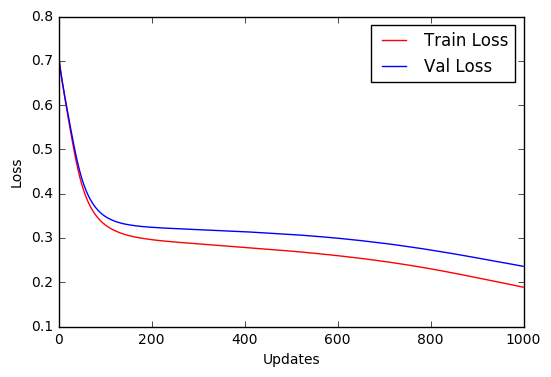

In [13]:
# defining a function to make predictions using our classifier
def pred(X_in, sess):
    # first we must define what data to give it
    feed_dict = {x_pl: X_in}
    # secondly our fetches
    fetches = [y]
    # utilizing the given session (ref. sess) to compute results
    res = sess.run(fetches, feed_dict)
    # res is a list with each indices representing the corresponding element in fetches
    return res[0]

# Training loop
num_epochs = 1000

train_cost, val_cost, val_acc = [],[],[]
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    
    # initializing all variables
    init = tf.initialize_all_variables()
    sess.run(init)
    plot_decision_boundary(lambda x: pred(x, sess), X_val, y_val)
    plt.title("Untrained Classifier")
    for e in range(num_epochs):
        ### TRAINING ###
        # what to feed to our train_op
        # notice we onehot encode our predictions to change shape from (batch,) -> (batch, num_output)
        feed_dict_train = {x_pl: X_tr, y_: onehot(y_tr, num_output)}
        
        # deciding which parts to fetch, train_op makes the classifier "train"
        fetches_train = [train_op, cross_entropy]
        
        # running the train_op
        res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
        # storing cross entropy (second fetch argument, so index=1)
        train_cost += [res[1]]
    
        ### VALIDATING ###
        # what to feed our accuracy op
        feed_dict_valid = {x_pl: X_val, y_: onehot(y_val, num_output)}

        # deciding which parts to fetch
        fetches_valid = [cross_entropy, accuracy]

        # running the validation
        res = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
        val_cost += [res[0]]
        val_acc += [res[1]]

        if e % 100 == 0:
            print("Epoch %i, Train Cost: %0.3f\tVal Cost: %0.3f\t Val acc: %0.3f" \
                  %(e, train_cost[-1],val_cost[-1],val_acc[-1]))

    ### TESTING ###
    # what to feed our accuracy op
    feed_dict_test = {x_pl: X_te, y_: onehot(y_te, num_output)}

    # deciding which parts to fetch
    fetches_test = [cross_entropy, accuracy]

    # running the validation
    res = sess.run(fetches=fetches_test, feed_dict=feed_dict_test)
    test_cost = res[0]
    test_acc = res[1]
    print("\nTest Cost: %0.3f\tTest Accuracy: %0.3f"%(test_cost, test_acc))
    
    # For plotting purposes
    plot_decision_boundary(lambda x: pred(x, sess), X_te, y_te)

# notice: we do not need to use the session environment anymore, so returning from it.
plt.title("Trained Classifier")

epoch = np.arange(len(train_cost))
plt.figure()
plt.plot(epoch,train_cost,'r',epoch,val_cost,'b')
plt.legend(['Train Loss','Val Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')

# Assignments Half Moon

 1) A linear logistic classifier is only able to create a linear decision boundary. Change the Logistic classifier into a (non-linear) Neural network by inserting a dense hidden layer between the input and output layers of the model
 
 2) Experiment with multiple hidden layers or more / less hidden units. What happens to the decision boundary?
 
 3) Overfitting: When increasing the number of hidden layers / units the neural network will fit the training data better by creating a highly nonlinear decision boundary. If the model is to complex it will often generalize poorly to new data (validation and test set). Can you obseve this from the training and validation errors? 
 
 4) We used the vanilla stocastic gradient descent algorithm for parameter updates. This is usually slow to converge and more sophisticated pseudo-second-order methods usually works better. Try changing the optimizer to [adam or momentum](https://www.tensorflow.org/versions/r0.10/api_docs/python/train.html#AdamOptimizer)

# Optional:  MNIST dataset
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into a 50,000 images training set, 10,000 images validation set and 10,000 images test set. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

### Primer for the afternoon...
We use a feedforward neural network to classify the 28x28 mnist images. ``num_features`` is therefore 28x28=784.
That is, we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance. (Your are of course encouraged to try this using ``numpy.random.permutation`` to get a random permutation :)). This task is therefore called the _permutation invariant_ MNIST. Obviously this throws away a lot of structure in the data. After lunch we'll fix this with the convolutional neural network wich encodes prior knowledgde about data that has either spatial or temporal structure.  

### Ballpark estimates of hyperparameters
__Optimizers:__
    1. SGD + Momentum: learning rate 1.0 - 0.1 
    2. ADAM: learning rate 3*1e-4 - 1e-5
    3. RMSPROP: somewhere between SGD and ADAM

__Regularization:__
    1. Dropout. Dropout rate 0.1-0.5
    2. L2 and L1 regularization - https://www.tensorflow.org/versions/r0.10/api_docs/python/contrib.layers.html#regularizers.
    Not used that often in deep learning, but 1e-4  -  1e-8.
    3. Batchnorm: Batchnorm also acts as a regularizer - https://www.tensorflow.org/versions/r0.10/api_docs/python/contrib.layers.html#batch_norm
    Often very useful (faster and better convergence)
    
    
__Parameter initialization__
    Parameter initialization is extremely important. TensorFlow has a lot of different initializers, check the TensorFlow API [documentation](https://www.tensorflow.org/versions/r0.10/api_docs/index.html). Often used initializer are
    1. He - (not available in TensorFlow's API)
    2. Glorot - https://www.tensorflow.org/versions/r0.10/api_docs/python/contrib.layers.html#xavier_initializer
    3. Uniform or Normal with small scale. (0.1 - 0.01) - https://www.tensorflow.org/versions/r0.10/api_docs/python/state_ops.html#random_normal_initializer
    4. Orthogonal (I find that this works very well for RNNs) - (not available in TensorFlow's API)

Bias is nearly always initialized to zero using the [tf.constant_initializer](https://www.tensorflow.org/versions/r0.10/api_docs/python/state_ops.html#constant_initializer).

__Number of hidden units and network structure__
   Probably as big network as possible and then apply regularization. You'll have to experiment :). One rarely goes below 512 units for feedforward networks unless your are training on CPU...
   Theres is some research into stochstic depth networks: https://arxiv.org/pdf/1603.09382v2.pdf, but in general this is trail and error.

__Nonlinearity__: [The most commonly used nonliearities are](https://www.tensorflow.org/versions/r0.10/api_docs/python/nn.html#activation-functions)
    
    1. ReLU
    2. Leaky ReLU. Same as 
    3. Elu
    3. Sigmoids are used if your output is binary. It is not used in the hidden layers. Squases the output between -1 and 1
    4. Softmax used as output if you have a classification problem. Normalizes the the output to 1. )


See the plot below.

__mini-batch size__
   Usually people use 16-256. Bigger is not allways better. With smaller mini-batch size you get more updates and your model might converge faster. Also small batchsizes uses less memory  -> you can train a model with more parameters.

Hyperparameters can be found by experience (guessing) or some search procedure. Random search is easy to implement and performs decent: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf . 
More advanced search procedures include [SPEARMINT](https://github.com/JasperSnoek/spearmint) and many others.

1.0


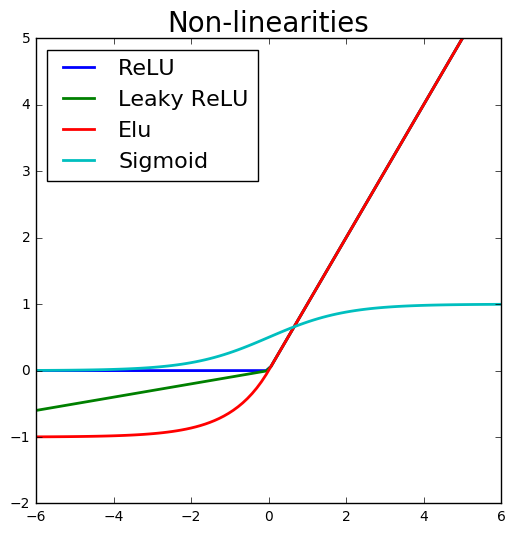

In [14]:
# PLOT OF DIFFERENT OUTPUT USNITS
x = np.linspace(-6, 6, 100)
relu = lambda x: np.maximum(0, x)
leaky_relu = lambda x: np.maximum(0, x) + 0.1*np.minimum(0, x) # probably a slow implementation....
elu = lambda x: (x > 0)*x + (1 - (x > 0))*(np.exp(x) - 1) 
sigmoid = lambda x: (1+np.exp(-x))**(-1)
def softmax(w, t = 1.0):
    e = np.exp(w)
    dist = e / np.sum(e)
    return dist
x_softmax = softmax(x)

plt.figure(figsize=(6,6))
plt.plot(x, relu(x), label='ReLU', lw=2)
plt.plot(x, leaky_relu(x), label='Leaky ReLU',lw=2)
plt.plot(x, elu(x), label='Elu', lw=2)
plt.plot(x, sigmoid(x), label='Sigmoid',lw=2)
plt.legend(loc=2, fontsize=16)
plt.title('Non-linearities', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])

# softmax
# assert that all class probablities sum to one
print(np.sum(x_softmax))
assert abs(1.0 - x_softmax.sum()) < 1e-8

## MNIST
First let's load the MNIST dataset and plot a few examples:

In [15]:
#To speed up training we'll only work on a subset of the data
data = np.load('mnist.npz')
num_classes = 10
x_train = data['X_train'][:1000].astype('float32')
targets_train = data['y_train'][:1000].astype('int32')

x_valid = data['X_valid'][:500].astype('float32')
targets_valid = data['y_valid'][:500].astype('int32')

x_test = data['X_test'][:500].astype('float32')
targets_test = data['y_test'][:500].astype('int32')

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
('x_train', (1000, 784))
('targets_train', (1000,))
('x_valid', (500, 784))
('targets_valid', (500,))
('x_test', (500, 784))
('targets_test', (500,))


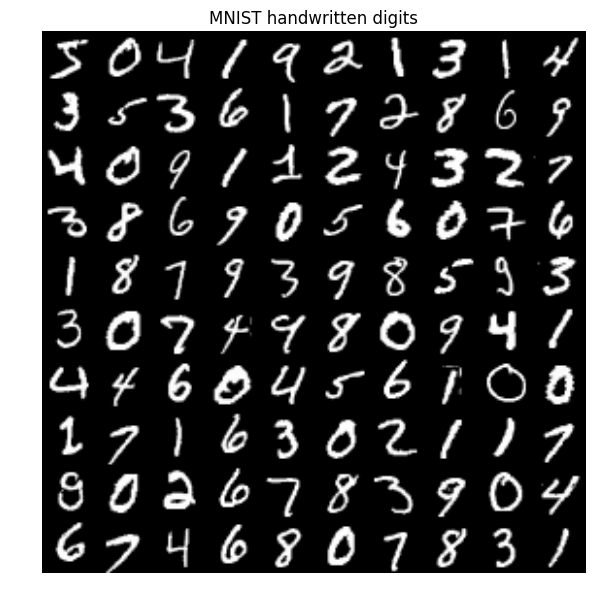

In [16]:
#plot a few MNIST examples
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

In [17]:
#Hyperparameters

num_classes = 10
num_l1 = 512
num_features = x_train.shape[1]

# resetting the graph ...
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
x_pl = tf.placeholder(tf.float32, [None, num_features])

# defining our weight initializers
weight_initializer = tf.truncated_normal_initializer(stddev=0.1)

# Setting up the trainable weights of the network
with tf.variable_scope('l_1'):
    W_1 = tf.get_variable('W', [num_features, num_l1],
                          initializer=weight_initializer)
    b_1 = tf.get_variable('b', [num_l1],
                          initializer=tf.constant_initializer(0.0))

with tf.variable_scope('l_2'):
    W_2 = tf.get_variable('W', [num_l1, num_classes],
                          initializer=weight_initializer)
    b_2 = tf.get_variable('b', [num_classes],
                          initializer=tf.constant_initializer(0.0))


# Building the layers of the neural network
l1 = tf.matmul(x_pl, W_1) + b_1
l1_nonlinear = tf.nn.elu(l1) # you can try with various activation functions!
l2 = tf.matmul(l1, W_2) + b_2
y = tf.nn.softmax(l2)

In [18]:
# y_ is a placeholder variable taking on the value of the target batch.
y_ = tf.placeholder(tf.float32, [None, num_classes])

# computing cross entropy per sample
cross_entropy = -tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])

# averaging over samples
loss_tn = tf.reduce_mean(cross_entropy)

# L2 regularization
#reg_scale = 0.0001
#regularize = tf.contrib.layers.l2_regularizer(reg_scale)
#params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
#reg_term = sum([regularize(param) for param in params])
#loss_tn += reg_term

# defining our optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

# applying the gradients
train_op = optimizer.minimize(loss_tn)

# notice, alternatively you can use train_op = optimizer.minimize(crossentropy)
# instead of the three steps above

In [19]:
#Test the forward pass
x = np.random.normal(0,1, (45, 28*28)).astype('float32') #dummy data

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.initialize_all_variables())
res = sess.run(fetches=[y], feed_dict={x_pl: x})
print("y", res[0].shape)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
('y', (45, 10))


# Build the training loop.
We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The paramters are updated after each mini batch. Networks converges much faster using minibatches because the paramters are updated more often.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``f_train`` is called.

Epoch 1 : Train Loss 2.092013e-01 , Train acc 0.706000,  Valid acc 0.628000 
Epoch 2 : Train Loss 6.533635e-02 , Train acc 0.860000,  Valid acc 0.764000 
Epoch 3 : Train Loss 4.764259e-02 , Train acc 0.887000,  Valid acc 0.772000 
Epoch 4 : Train Loss 4.038003e-02 , Train acc 0.899000,  Valid acc 0.780000 
Epoch 5 : Train Loss 3.558081e-02 , Train acc 0.918000,  Valid acc 0.794000 
Epoch 6 : Train Loss 3.202858e-02 , Train acc 0.924000,  Valid acc 0.802000 
Epoch 7 : Train Loss 2.922359e-02 , Train acc 0.934000,  Valid acc 0.798000 
Epoch 8 : Train Loss 2.691437e-02 , Train acc 0.937000,  Valid acc 0.806000 
Epoch 9 : Train Loss 2.495763e-02 , Train acc 0.947000,  Valid acc 0.808000 
Epoch 10 : Train Loss 2.326436e-02 , Train acc 0.952000,  Valid acc 0.810000 
Epoch 11 : Train Loss 2.177584e-02 , Train acc 0.959000,  Valid acc 0.812000 
Epoch 12 : Train Loss 2.045144e-02 , Train acc 0.965000,  Valid acc 0.812000 
Epoch 13 : Train Loss 1.926180e-02 , Train acc 0.966000,  Valid acc 0.814

(<matplotlib.text.Text at 0x7f6dc04c9510>,
 <matplotlib.text.Text at 0x7f6dc04e5b10>)

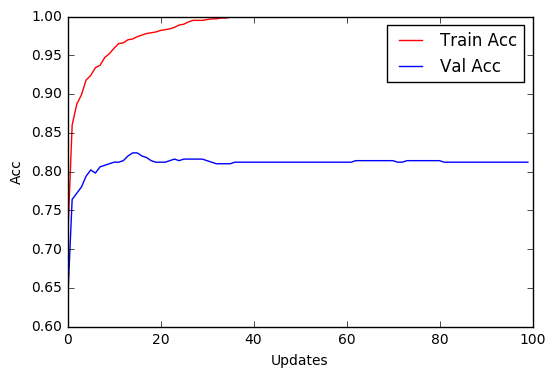

In [20]:
# using confusionmatrix to handle 
from confusionmatrix import ConfusionMatrix

# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 100
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
loss = []
## TRAINING ##
for epoch in range(num_epochs):
    #Forward->Backprob->Update params
    cur_loss = 0
    for i in range(num_batches_train):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_train[idx]
        target_batch = targets_train[idx]
        feed_dict_train = {x_pl: x_batch, y_: onehot(target_batch, num_classes)}
        fetches_train = [train_op, loss_tn]
        res = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
        batch_loss = res[1]
        cur_loss += batch_loss
    loss += [cur_loss/batch_size]
    
    confusion_valid = ConfusionMatrix(num_classes)
    confusion_train = ConfusionMatrix(num_classes)

    ### EVAL - TRAIN ###
    for i in range(num_batches_train):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_train[idx]
        targets_batch = targets_train[idx]
        # what to feed our accuracy op
        feed_dict_eval_train = {x_pl: x_batch, y_: onehot(targets_batch, num_classes)}
        # deciding which parts to fetch
        fetches_eval_train = [y]
        # running the validation
        res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
        # collecting and storing predictions
        net_out = res[0]
        preds = np.argmax(net_out, axis=-1)
        confusion_train.batch_add(targets_batch, preds)

    ### EVAL - VALIDATION ###
    confusion_valid = ConfusionMatrix(num_classes)
    for i in range(num_batches_valid):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_valid[idx]
        targets_batch = targets_valid[idx]
        # what to feed our accuracy op
        feed_dict_eval_train = {x_pl: x_batch, y_: onehot(targets_batch, num_classes)}
        # deciding which parts to fetch
        fetches_eval_train = [y]
        # running the validation
        res = sess.run(fetches=fetches_eval_train, feed_dict=feed_dict_eval_train)
        # collecting and storing predictions
        net_out = res[0]
        preds = np.argmax(net_out, axis=-1) 
        confusion_valid.batch_add(targets_batch, preds)
    
    train_acc_cur = confusion_train.accuracy()
    valid_acc_cur = confusion_valid.accuracy()

    train_acc += [train_acc_cur]
    valid_acc += [valid_acc_cur]
    print("Epoch %i : Train Loss %e , Train acc %f,  Valid acc %f " \
    % (epoch+1, loss[-1], train_acc_cur, valid_acc_cur))
    
    
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch,train_acc,'r',epoch,valid_acc,'b')
plt.legend(['Train Acc','Val Acc'])
plt.xlabel('Updates'), plt.ylabel('Acc')

# More questions

1. Do you see overfitting? Google overfitting if you don't know how to spot it
2. Try and regularize your network by penalizing the L2 or L1 norm of the network parameters. [Read the docs for more info](https://www.tensorflow.org/versions/r0.10/api_docs/python/contrib.layers.html#regularizers)